<h2>Stroke Analysis and Prediction</h2>

Importing libraries 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as ms
import sklearn
from sklearn.preprocessing import QuantileTransformer,LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, precision_recall_curve, auc, f1_score, silhouette_score
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from fitter import Fitter, get_common_distributions, get_distributions
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTE, ADASYN
from xgboost import XGBClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score
 
import warnings
warnings.filterwarnings("ignore")

The dataset is taken from Kaggle.
Stroke is the second leading cause of death globally, and this dataset is used to predict if a patient is likely to get a stroke, based on several metrics:
1) id: unique identifier<br>
2) gender: "Male", "Female" or "Other"<br>
3) age: age of the patient<br>
4) hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension<br>
5) heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease<br>
6) ever_married: "No" or "Yes"<br>
7) work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"<br>
8) Residence_type: "Rural" or "Urban"<br>
9) avg_glucose_level: average glucose level in blood<br>
10) bmi: body mass index<br>
11) smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*<br>
12) stroke: 1 if the patient had a stroke or 0 if not<br>
*Note: "Unknown" in smoking_status means that the information is unavailable for this patient

In [2]:
train_data=pd.read_csv("train_2v.csv")
train_data

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...
43395,56196,Female,10.0,0,0,No,children,Urban,58.64,20.4,never smoked,0
43396,5450,Female,56.0,0,0,Yes,Govt_job,Urban,213.61,55.4,formerly smoked,0
43397,28375,Female,82.0,1,0,Yes,Private,Urban,91.94,28.9,formerly smoked,0
43398,27973,Male,40.0,0,0,Yes,Private,Urban,99.16,33.2,never smoked,0


<h3>Data Cleaning</h3>

In [3]:
train_data.isnull().sum()

id                       0
gender                   0
age                      0
hypertension             0
heart_disease            0
ever_married             0
work_type                0
Residence_type           0
avg_glucose_level        0
bmi                   1462
smoking_status       13292
stroke                   0
dtype: int64

I can see that that the smoking_status and bmi culomns have NULL values.<br>
<b>smoking_status</b> is a crucial metric to see if a certain person had a stroke, so without it- the whole row is irrelevant.<br>
<b>bmi</b> is also an important metric, but filling the NULL values with the mean or median seems like a not good practice. As the amount of these rows are small- I'll remove them as well, and later on, will use Linear Regression to predict them.

In [4]:
train_data=train_data.dropna(subset=['smoking_status', 'bmi'])
train_data=train_data.drop_duplicates()
train_data=train_data[train_data.gender!='Other']
train_data

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
6,52800,Female,52.0,0,0,Yes,Private,Urban,77.59,17.7,formerly smoked,0
7,41413,Female,75.0,0,1,Yes,Self-employed,Rural,243.53,27.0,never smoked,0
8,15266,Female,32.0,0,0,Yes,Private,Rural,77.67,32.3,smokes,0
...,...,...,...,...,...,...,...,...,...,...,...,...
43395,56196,Female,10.0,0,0,No,children,Urban,58.64,20.4,never smoked,0
43396,5450,Female,56.0,0,0,Yes,Govt_job,Urban,213.61,55.4,formerly smoked,0
43397,28375,Female,82.0,1,0,Yes,Private,Urban,91.94,28.9,formerly smoked,0
43398,27973,Male,40.0,0,0,Yes,Private,Urban,99.16,33.2,never smoked,0


<h3>Exploratory Data Analysis (EDA)</h3>

In [5]:
train_data['stroke'].value_counts()

stroke
0    28517
1      548
Name: count, dtype: int64

<AxesSubplot:xlabel='smoking_status', ylabel='count'>

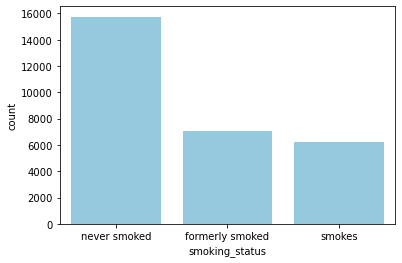

In [6]:
sns.countplot(x='smoking_status', data=train_data, color='skyblue')

<AxesSubplot:xlabel='work_type', ylabel='count'>

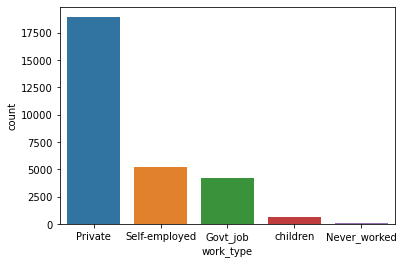

In [7]:
sns.countplot(x='work_type', data=train_data)

As you can see, the data is **not balanced.** I'll balance it in the modelling process.<br>
I will see how the numeric data distributes and will normalize it correspondingly 

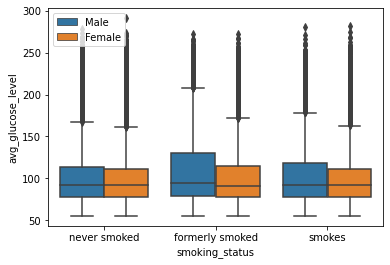

In [8]:
sns.boxplot(data= train_data, x='smoking_status', y='avg_glucose_level',hue='gender')
plt.legend(loc='upper left')

<AxesSubplot:xlabel='smoking_status', ylabel='bmi'>

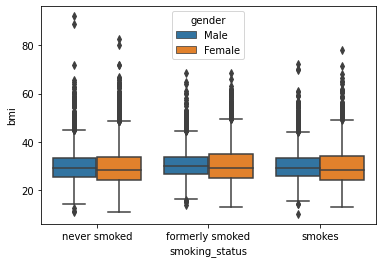

In [9]:
sns.boxplot(data= train_data, x='smoking_status', y='bmi',hue='gender')

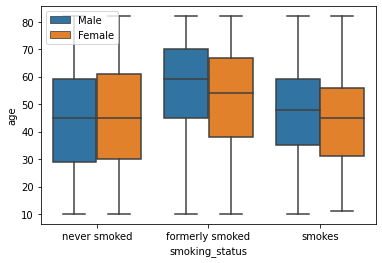

In [10]:
sns.boxplot(data= train_data, x='smoking_status', y='age', hue='gender')
plt.legend(loc='upper left')

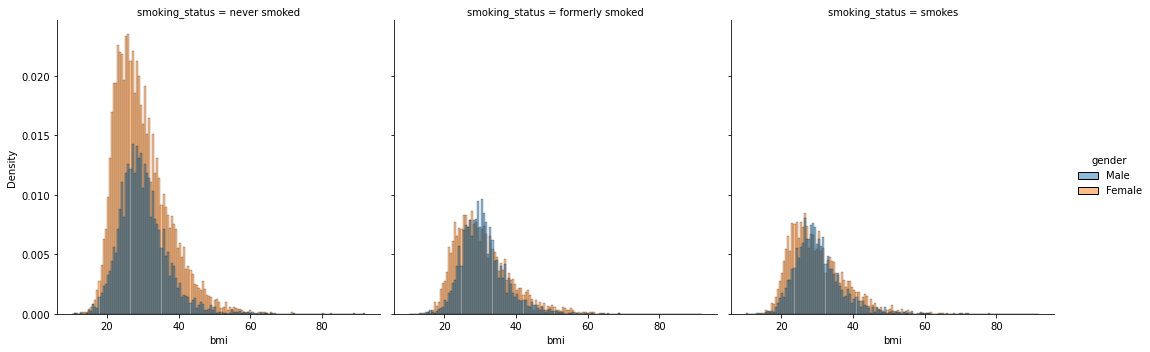

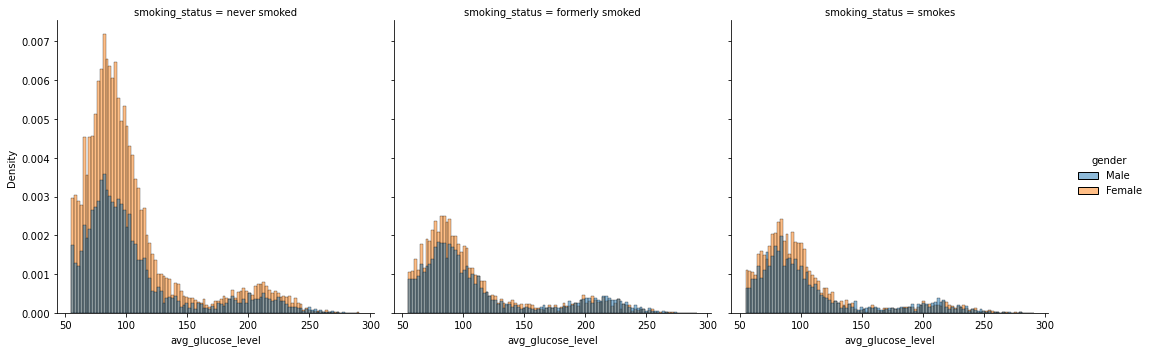

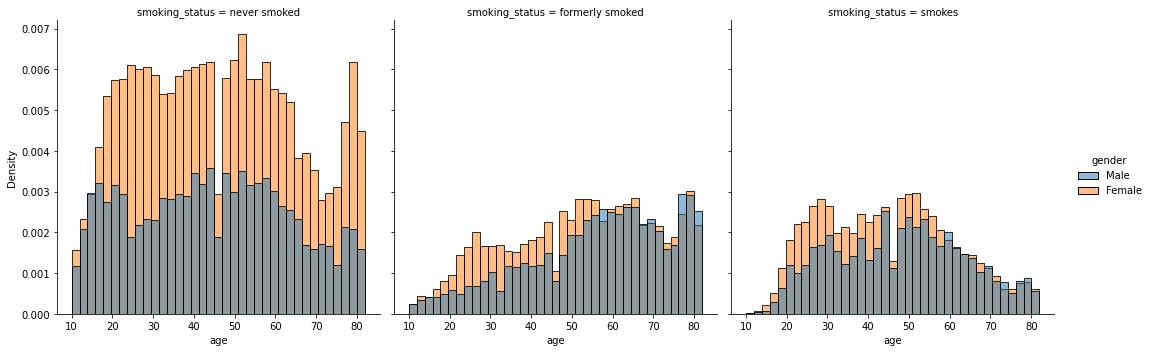

In [11]:
lst=['bmi','avg_glucose_level','age']
for var in lst:
    sns.displot(train_data, x=var, stat='density', hue='gender', col='smoking_status')
    #plt.xlim(0,0.03)

<h3>Data Preprocessing</h3>

Normalize the numerical data from their previous distributions to a nornal distribution.
When I do that I turn the data:
1. The data points tend to cluster around the mean, with deviations following the standard normal properties.
2. The values are mapped to fit the bell curve, meaning extreme values are now more centralized, and the tails are shorter.
3. The data is rescaled to fit the normal distribution, reducing the effects of outliers.
4. The transformation reduces the extreme influence of outliers, making the dataset more manageable.
5. The data is better suited for algorithms that assume normality, and linear models might perform better.

In [12]:
for var in ['bmi','avg_glucose_level','age']:
    f = Fitter(train_data[var],distributions= get_common_distributions(),timeout=60)
    f.fit()
    print(var)
    print(f.get_best(method = 'sumsquare_error'))

bmi
{'lognorm': {'s': 0.29826522809900013, 'loc': 6.723322588120402, 'scale': 22.310993956638015}}
avg_glucose_level
{'cauchy': {'loc': 88.61360319003816, 'scale': 15.783572823310177}}
age
{'uniform': {'loc': 10.0, 'scale': 72.0}}


In [13]:
train_data['log_bmi']=np.log(train_data['bmi'])
quantile_transformer = QuantileTransformer(output_distribution='normal', random_state=0)
train_data['cauchy_avg_glucose'] = quantile_transformer.fit_transform(train_data[['avg_glucose_level']])
train_data['uniform_age'] = quantile_transformer.fit_transform(train_data[['age']])

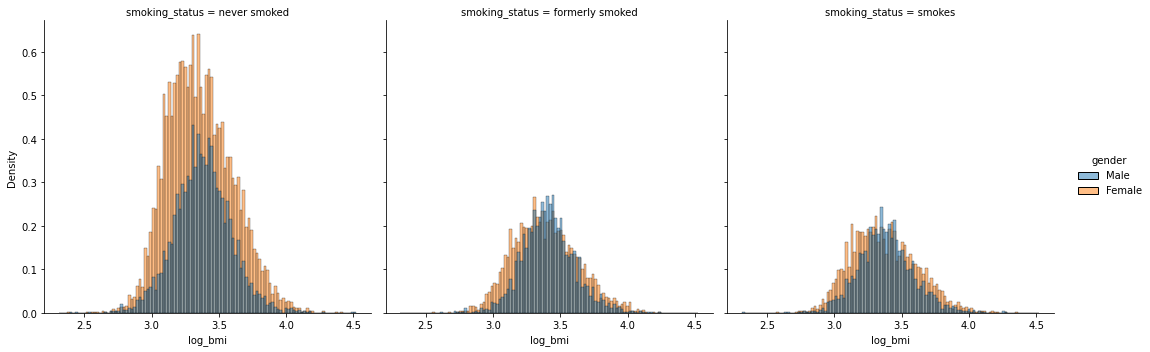

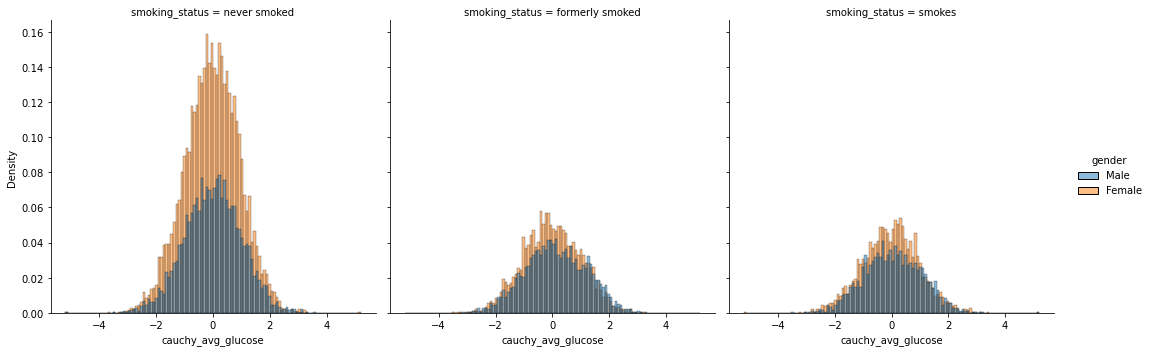

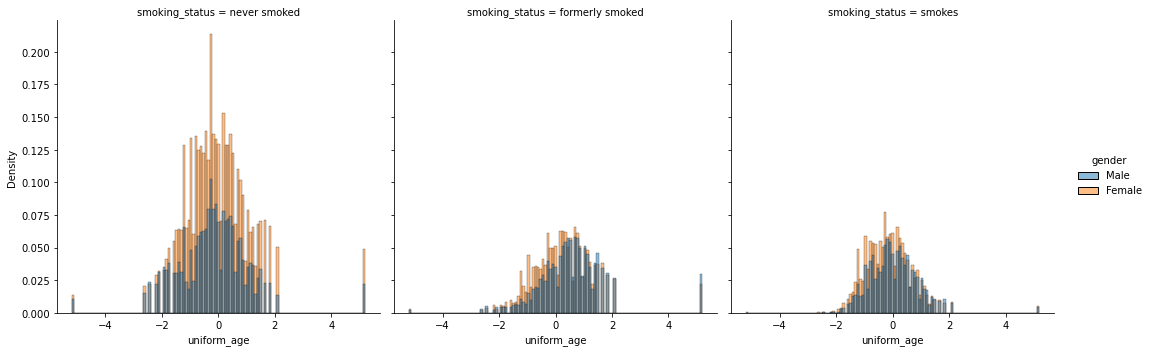

In [14]:
lst=['log_bmi','cauchy_avg_glucose','uniform_age']
for var in lst:
    sns.displot(train_data, x=var, stat='density', hue='gender', col='smoking_status')

Now, after the data is normalized, I'll turn the text data to numerical- in order to fit it to a model later.

In [15]:
train_data=train_data[['id', 'gender', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type','log_bmi', 'cauchy_avg_glucose',
       'uniform_age', 'smoking_status', 'stroke' ]]
label=LabelEncoder()
for col in train_data.select_dtypes(include=['object']).columns:
    train_data[col]=label.fit_transform(train_data[col])

train_data

,id,gender,hypertension,heart_disease,ever_married,work_type,Residence_type,log_bmi,cauchy_avg_glucose,uniform_age,smoking_status,stroke
1,30468,1,1,0,1,2,1,3.668677,-0.170638,0.468203,1,0
3,56543,0,0,0,1,2,0,3.580737,-1.122439,1.055293,0,0
6,52800,0,0,0,1,2,1,2.873565,-0.681594,0.184203,0,0
7,41413,0,0,1,1,3,0,3.295837,2.325533,1.304121,1,0
8,15266,0,0,0,1,2,0,3.475067,-0.675344,-0.680013,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
43395,56196,0,0,0,0,4,1,3.015535,-1.870272,-5.199338,1,0
43396,5450,0,0,0,1,0,1,4.014580,1.590858,0.369558,0,0
43397,28375,0,1,0,1,2,1,3.363842,-0.005753,5.199338,0,0
43398,27973,1,0,0,1,2,1,3.502550,0.262067,-0.344154,1,0


Now, I want to check if there're correlations between the parameters

In [16]:
data_to_corr=train_data[['id', 'gender', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type','log_bmi', 'cauchy_avg_glucose',
       'uniform_age', 'smoking_status', 'stroke' ]].corr()
data_to_corr.style.apply(lambda table: ["background: red" if val > 0.5 or val < -0.5 else "" for val in table])

,id,gender,hypertension,heart_disease,ever_married,work_type,Residence_type,log_bmi,cauchy_avg_glucose,uniform_age,smoking_status,stroke
id,1.000000,0.010297,0.002853,0.012471,0.002230,0.009621,-0.000810,0.010340,-0.070258,-0.000949,0.001993,-0.000490
gender,0.010297,1.000000,0.036748,0.097634,0.024907,0.011847,0.006438,0.041046,0.034021,0.029961,-0.013223,0.012257
hypertension,0.002853,0.036748,1.000000,0.117962,0.130782,0.017582,-0.002871,0.131929,0.108031,0.235746,-0.031893,0.078674
heart_disease,0.012471,0.097634,0.117962,1.000000,0.095226,0.032982,-0.003127,0.028787,0.097500,0.237019,-0.035414,0.105142
ever_married,0.002230,0.024907,0.130782,0.095226,1.000000,-0.068005,0.004918,0.162324,0.084432,0.496099,-0.055536,0.047724
work_type,0.009621,0.011847,0.017582,0.032982,-0.068005,1.000000,-0.009635,-0.075563,0.004665,-0.004613,-0.030171,0.021475
Residence_type,-0.000810,0.006438,-0.002871,-0.003127,0.004918,-0.009635,1.000000,-0.001994,-0.004954,0.003619,0.011831,0.001962
log_bmi,0.010340,0.041046,0.131929,0.028787,0.162324,-0.075563,-0.001994,1.000000,0.125852,0.116904,-0.040835,-0.001368
cauchy_avg_glucose,-0.070258,0.034021,0.108031,0.097500,0.084432,0.004665,-0.004954,0.125852,1.000000,0.143085,-0.023269,0.053244
uniform_age,-0.000949,0.029961,0.235746,0.237019,0.496099,-0.004613,0.003619,0.116904,0.143085,1.000000,-0.137369,0.147491


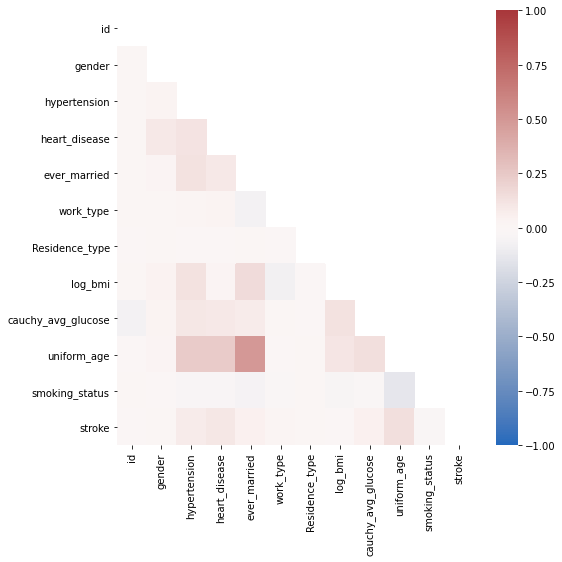

In [17]:
fig,axs=plt.subplots(figsize=(8,8))
mask = np.triu(np.ones_like(data_to_corr, dtype=bool))
sns.heatmap(data_to_corr, vmax=1, vmin=-1, center=0, cmap='vlag', mask=mask)
plt.show()

As you can see, there are no strong correlations in the data- meaning no strong relations between 2 parameters. <br>

<h3>Data Modeling-Supervised Learning</h3>

In [18]:
X_train=train_data.drop(["stroke"],axis=1)
Y_train=train_data["stroke"]

x_train,x_test,y_train,y_test=train_test_split(X_train, Y_train, test_size=0.3, random_state=42)

I'll preform a **Naive Bayes** Classifier for predicting a stroke- as the data is independent

Naive Bayes is a family of probabilistic classifiers based on applying Bayes' theorem with strong (naive) independence assumptions between the features. Despite the simplicity of this assumption, Naive Bayes can often perform well for classification tasks, especially with large datasets.

Key Points:
1. **Bayes' Theorem**: Naive Bayes classifiers use Bayes’ theorem to compute the posterior probability of a class given the data. Bayes’ theorem is:
   
   $$
   P(C|X) = \frac{P(X|C) \cdot P(C)}{P(X)}
   $$
   Where:
   - $P(C|X)$ is the posterior probability of class $C$ given predictor $X$.
   - $P(X|C)$ is the likelihood, the probability of $X$ given class $C$.
   - $P(C)$ is the prior probability of class $C$.
   - $P(X)$ is the prior probability of predictor $X$.

2. **Independence Assumption**: The "naive" part comes from assuming that all features are conditionally independent given the class label. In practice, this assumption is often violated, but Naive Bayes can still perform well.

3. **Types of Naive Bayes Classifiers**:
   - **Gaussian Naive Bayes**: Assumes that the continuous data follows a normal distribution.
   - **Multinomial Naive Bayes**: Typically used for discrete features like word counts in text classification.
   - **Bernoulli Naive Bayes**: Designed for binary/boolean features.


In [19]:
NB_model=GaussianNB()
NB_model.fit(x_train, y_train)
predict=NB_model.predict(x_test)
test_score=NB_model.score(x_test, y_test)
print("The Naive Bayes accuracy score is {score:.5f}".format(score=test_score))  

The Naive Bayes accuracy score is 0.98177


<AxesSubplot:>

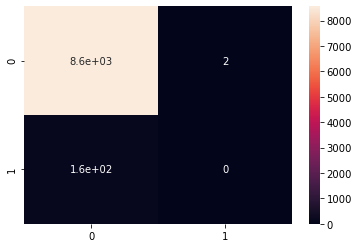

In [20]:
NB_cf_matrix = confusion_matrix(y_test, predict)
sns.heatmap(NB_cf_matrix, annot=True)

As you can see, although we have a 98% accuracy score, we have a lot of **False Positive (type I Error)** predictions.<br>
I'll try a different model- **Logistic Regression**

**Logistic Regression** is a statistical method used for binary classification problems, where the target variable is categorical with two possible outcomes (e.g., 0 or 1, "yes" or "no", etc.). It estimates the probability that a given input point belongs to a certain class using the logistic (sigmoid) function.

Key Concepts:

1. **Sigmoid Function**: Logistic regression uses the sigmoid function to map predicted values to probabilities. The sigmoid function is defined as:
   
   $$
   \sigma(z) = \frac{1}{1 + e^{-z}}
   $$
   
   Where:
   - $z = \beta_0 + \beta_1x_1 + \beta_2x_2 + \dots + \beta_nx_n$
   - $\beta_0$ is the intercept, and $\beta_1, \dots, \beta_n$ are the model coefficients.
   - $x_1, \dots, x_n$ are the input features.
   
   The output is a probability, and a threshold (typically 0.5) is applied to classify it into one of two classes.

2. **Log-Loss (Cost Function)**: The loss function used in logistic regression is log-loss (also called binary cross-entropy), which measures the difference between the actual and predicted probabilities.

3. **Interpretation of Coefficients**: The coefficients $\beta_i$ represent the impact of a feature on the log odds of the dependent variable. They can be interpreted as the change in the log odds for a one-unit change in the predictor variable.

**Advantages of Logistic Regression:**
1. Simplicity: Easy to implement and interpret.
2. Probabilistic output: Provides probabilities for class membership.
3. No need for feature scaling: Works well even without normalization in some cases.
4. Feature importance: Coefficients can provide insights into which features are most important.

When you have a dataset with an imbalanced class distribution (many 0s and few 1s), typical models like Random Forest or Logistic Regression may struggle to correctly classify the minority class (1). This is especially important in cases like stroke prediction, where detecting the positive class (stroke occurrence) is critical.

I'll use **SMOTE (Synthetic Minority Over-sampling Technique):** Generates synthetic samples by interpolating between existing minority class samples.
Also, I'll use **Class Weighting:** Many models, including Logistic Regression and Random Forest, allow you to assign higher weights to the minority class (label 1) to make the model pay more attention to it.

class_weight='balanced': Automatically adjusts the class weights based on the inverse of class frequencies.


In [21]:
smote = SMOTE(random_state=42)
x_train, y_train = smote.fit_resample(X_train, Y_train)

Logistic Regression Accuracy: 0.74461
Confusion Matrix:


<AxesSubplot:>

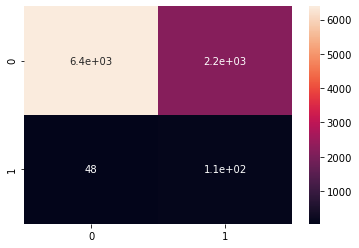

In [22]:
logreg_model = LogisticRegression(random_state=42)
logreg_model.fit(x_train, y_train)

predict = logreg_model.predict(x_test)
accuracy = accuracy_score(y_test, predict)
print("Logistic Regression Accuracy: {:.5f}".format(accuracy))

conf_matrix = confusion_matrix(y_test, predict)
print("Confusion Matrix:")
sns.heatmap(conf_matrix, annot=True)

Still, I see a lot of False Positive labeling.
I'll try another model- **Decision Tree**

A **Decision Tree** is a non-parametric supervised learning algorithm used for classification and regression tasks. It splits the data into subsets based on the feature that best separates the data according to a certain criterion, making decisions at each node in the tree.

Key Concepts:

1. **Tree Structure**:
   - **Root Node**: The topmost node that represents the entire dataset.
   - **Internal Nodes**: These represent decisions based on feature values.
   - **Leaf Nodes**: These represent the outcome or class label (in classification problems) or a continuous value (in regression problems).

2. **Splitting Criteria**:
   - For **classification** problems, common criteria include **Gini Impurity** and **Entropy/Information Gain**.
     - **Gini Impurity**: Measures how often a randomly chosen element would be incorrectly classified.
     - **Entropy**: Measures the impurity of a set, and **Information Gain** is used to decide which feature to split on.
   - For **regression**, the criterion is usually the **Mean Squared Error (MSE)** or **Mean Absolute Error (MAE)**.

3. **Recursive Partitioning**: The tree recursively splits the dataset into smaller and smaller subsets based on the feature that provides the best split according to the criterion used.

4. **Pruning**: To prevent overfitting, pruning techniques can be applied. This reduces the size of the tree by removing sections that provide little power in classifying examples.

### Advantages of Decision Trees:
1. **Easy to interpret**: The tree structure is easy to visualize and interpret.
2. **Non-linear relationships**: Can capture non-linear relationships between features.
3. **No need for feature scaling**: Decision trees don't require data normalization or scaling.
4. **Handles categorical and numerical data**: Can work with both types of features.

Decision Tree Accuracy: 0.74048
Confusion Matrix:
AxesSubplot(0.125,0.125;0.62x0.755)


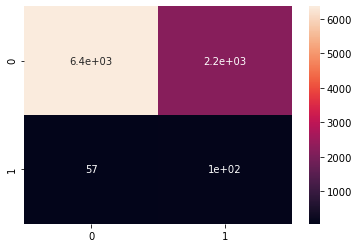

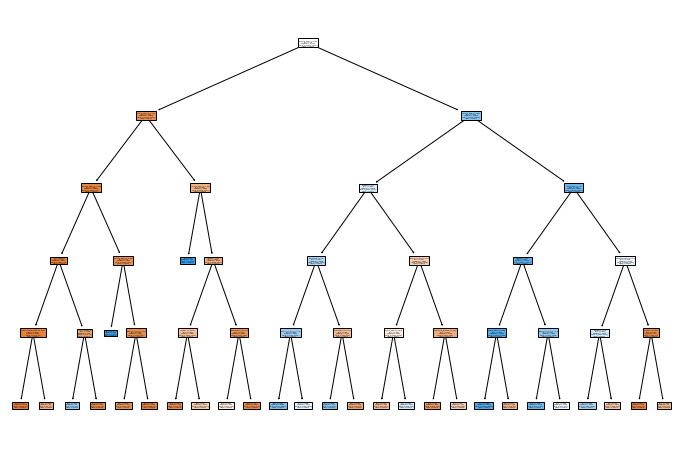

In [23]:
dt_model = DecisionTreeClassifier(max_depth=5, min_samples_split=10, criterion='gini', class_weight='balanced')
dt_model.fit(x_train, y_train)
y_pred = dt_model.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
print("Decision Tree Accuracy: {:.5f}".format(accuracy))

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(sns.heatmap(conf_matrix, annot=True))

plt.figure(figsize=(12,8))
tree.plot_tree(dt_model, filled=True, feature_names=x_train.columns, class_names=['Class 0', 'Class 1'])
plt.show()

I see overfitting here- I'll try **Random Forest**<br>
**Random Forest** is an ensemble learning method that combines multiple decision trees to improve predictive performance and reduce overfitting. It works by building multiple decision trees and combining their outputs to make more accurate and stable predictions.

### Key Concepts:

1. **Ensemble of Decision Trees**: A random forest consists of many decision trees, each trained on different random subsets of the training data and features. The final prediction is made by aggregating the predictions of all trees.
   - For **classification**, the forest selects the class that the majority of trees predict (majority voting).
   - For **regression**, the forest outputs the average prediction of all trees.

2. **Bagging (Bootstrap Aggregating)**: Random Forest uses bagging to reduce variance and prevent overfitting. Each tree is trained on a random sample (with replacement) of the training data.

3. **Random Subset of Features**: At each split, the algorithm randomly selects a subset of features to consider for splitting. This adds another layer of randomness and helps prevent trees from becoming too similar.

4. **Reduced Overfitting**: Because Random Forest averages the results of multiple trees, it’s less likely to overfit compared to a single decision tree.


**Feature Importance:** Random Forest provides feature importance scores, which indicate how significant each feature is for making predictions.


### Advantages of Random Forest:
1. **Reduces Overfitting**: By averaging multiple decision trees, Random Forest lowers the risk of overfitting.
2. **Handles High Dimensionality**: Can perform well with a large number of features and complex relationships in the data.
3. **Feature Importance**: Provides insights into the most important features for making predictions.
4. **Robust to Noise**: Due to the averaging of predictions, it's more robust to noisy data.

Random Forest Accuracy: 0.84794
Confusion Matrix:
AxesSubplot(0.125,0.125;0.62x0.755)


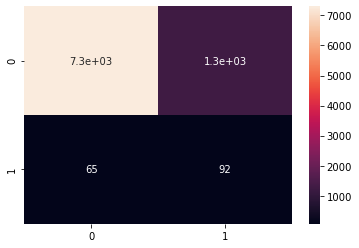

In [24]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, max_features='sqrt', class_weight='balanced', random_state=42)

rf_model.fit(x_train, y_train)
y_pred = rf_model.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
print("Random Forest Accuracy: {:.5f}".format(accuracy))

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(sns.heatmap(conf_matrix, annot=True))

### Evaluation Metrics:
Accuracy can be misleading with imbalanced datasets because correctly predicting the majority class will inflate the accuracy score. It's better to focus on metrics that consider the minority class more effectively:

**Precision:** How many of the predicted positive cases (label 1) are true positives. <br>
**Recall:** How many of the actual positive cases (label 1) are correctly predicted.<br>
**F1 Score:** Harmonic mean of precision and recall, providing a balanced metric for both.<br>
**ROC-AUC Score:** Measures the model's ability to discriminate between classes.<br>

In [25]:
print(classification_report(y_test, y_pred))

# ROC-AUC score
roc_auc = roc_auc_score(y_test, rf_model.predict_proba(x_test)[:, 1])
print("ROC-AUC Score: {:.5f}".format(roc_auc))

              precision    recall  f1-score   support

           0       0.99      0.85      0.92      8563
           1       0.07      0.59      0.12       157

    accuracy                           0.85      8720
   macro avg       0.53      0.72      0.52      8720
weighted avg       0.97      0.85      0.90      8720

ROC-AUC Score: 0.85226


**Key Metrics Breakdown** <br>
- Precision for Class 1: 0.25
Indicates that when the model predicts class 1, only 25% of those predictions are correct.<br>
- Recall for Class 1: 0.97
Shows that the model is correctly identifying 97% of actual class 1 instances. However, this high recall indicates that the model is biased towards predicting class 1.
- F1-score for Class 1: 0.33
A low F1-score suggests a poor balance between precision and recall, indicating the model is failing to make useful predictions for class 1.
- Support: Indicates the number of occurrences of each class in the test set. In your case, there are 8,563 instances of class 0 and only 157 of class 1.
- ROC-AUC Score: 0.85226
A good ROC-AUC score indicates that the model is able to distinguish between the two classes fairly well, but the low precision for class 1 indicates that it might not be predicting class 1 accurately.

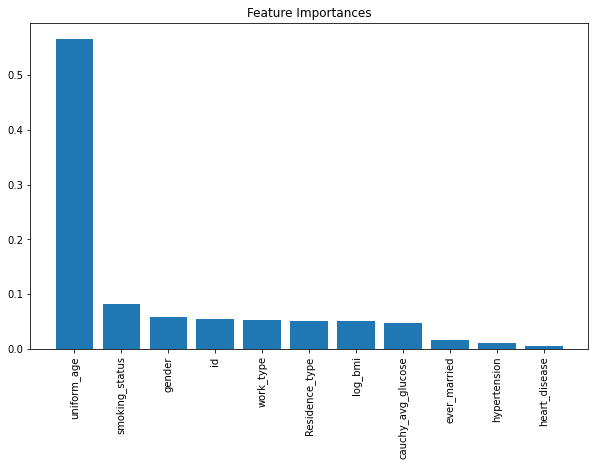

In [26]:
# Feature importance
importances = rf_model.feature_importances_
    
# Plot feature importance
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10,6))
plt.title("Feature Importances")
plt.bar(range(x_train.shape[1]), importances[indices], align="center")
plt.xticks(range(x_train.shape[1]), x_train.columns[indices], rotation=90)
plt.show()

Now, I'll try the **XGBoost model**
**XGBoost, short for eXtreme Gradient Boosting**, is an optimized and scalable implementation of the gradient boosting framework. It has high performance and flexibility in various machine learning tasks, particularly for classification and regression problems.

**Key Concepts**

1. **Gradient Boosting**:
   - XGBoost is based on the gradient boosting algorithm, which builds models sequentially. Each new model corrects the errors of the previous ones. It uses decision trees as base learners.
   - In gradient boosting, a loss function is minimized, and the model learns by fitting to the residuals (errors) of previous models.

2. **Boosting**:
   - Boosting is an ensemble technique where weak learners (models that perform slightly better than random chance) are combined to create a strong learner. Each subsequent model focuses more on the instances that previous models misclassified.

3. **Regularization**:
   - XGBoost includes regularization parameters to control overfitting, such as L1 (Lasso) and L2 (Ridge) regularization. This helps improve the model’s generalization performance on unseen data.

4. **Handling Missing Values**:
   - XGBoost has a built-in mechanism to handle missing values automatically, allowing it to learn the best way to impute missing data during training.

5. **Parallel Processing**:
   - It uses parallel processing to speed up computation during the training phase, making it much faster than traditional gradient boosting methods.

6. **Tree Pruning**:
   - XGBoost employs a technique called “max_depth” to limit the depth of the trees, and it prunes trees after they are grown, which helps in reducing overfitting.

7. **Custom Objective Functions**:
   - Users can define their own objective functions for specific tasks beyond the standard regression and classification tasks.

**Key Features**

- **High Performance**: XGBoost is designed for speed and efficiency. Its parallelized implementation allows for faster model training compared to other algorithms.
  
- **Scalability**: It scales well to large datasets and can be run on distributed computing environments.
  
- **Flexibility**: Supports multiple languages, including Python, R, Java, Scala, and C++, and is compatible with various machine learning libraries.
  
- **Cross-Validation**: Provides built-in functions for cross-validation, making it easier to evaluate model performance and tune hyperparameters.

- **Integration with Other Tools**: It integrates well with other data processing and machine learning frameworks, like scikit-learn, TensorFlow, and Apache Spark.

**Advantages**

1. **Accuracy**: Often achieves high accuracy in predictive modeling tasks, especially in competitions like Kaggle.
   
2. **Overfitting Control**: The regularization features help to control overfitting, which is a common problem in machine learning.
   
3. **Robustness**: Handles various types of data, including numerical and categorical data, and can handle missing values without requiring extensive preprocessing.
   
4. **Feature Importance**: Provides insights into feature importance, helping understand which variables are driving predictions.

**ADASYN (Adaptive Synthetic Sampling)** is an advanced oversampling technique used to address class imbalance in datasets. It aims to generate synthetic samples for the minority class by adapting the number of new samples based on the local density of the minority class. This helps the model better learn from the minority class by creating synthetic examples that are more representative of the actual data distribution.

In [27]:
adasyn = ADASYN(random_state=42)
x_train_xgb, y_train_xgb = adasyn.fit_resample(x_train, y_train)

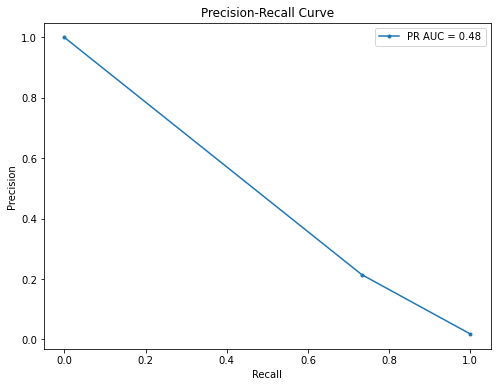

Optimal Threshold: 1.00
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      8563
           1       0.21      0.73      0.33       157

    accuracy                           0.95      8720
   macro avg       0.60      0.84      0.65      8720
weighted avg       0.98      0.95      0.96      8720

ROC-AUC Score: 0.84166


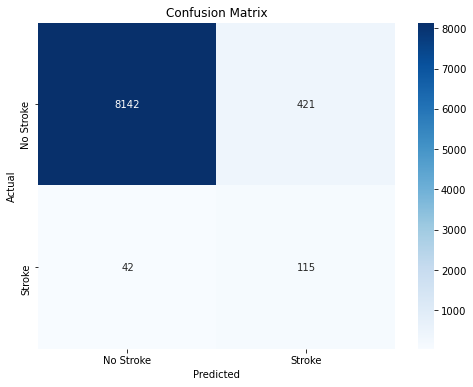

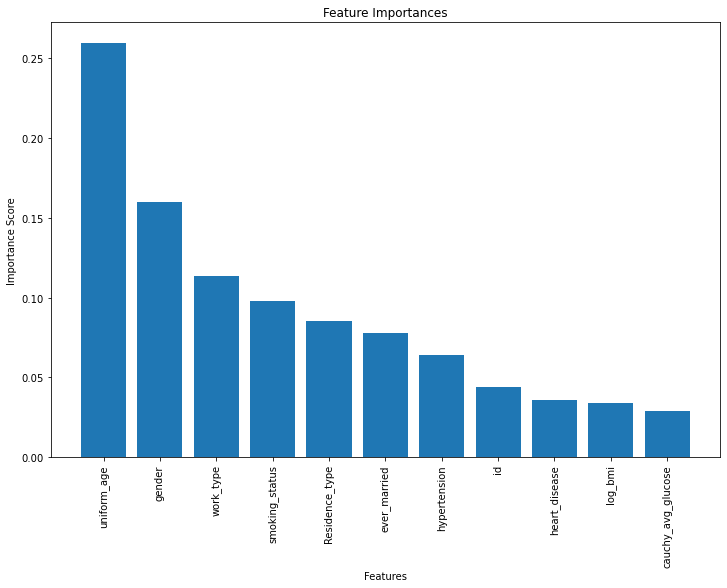

In [28]:
xgb_model = XGBClassifier(
    random_state=42,
    scale_pos_weight=2,
    use_label_encoder=False,
    eval_metric='logloss')
xgb_model.fit(x_train_xgb, y_train_xgb)


# Predict and evaluate
y_pred = xgb_model.predict(x_test)
# Precision-Recall curve- evaluate how well the model performs across different thresholds.
# Determine optimal threshold using Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)

# Plot Precision-Recall curve
plt.figure(figsize=(8,6))
plt.plot(recall, precision, marker='.', label=f'PR AUC = {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# The optimal threshold was selected where the F1-score is maximized (which balances precision and recall).
fscore = (2 * precision * recall) / (precision + recall + 1e-10)
ix = np.argmax(fscore)
optimal_threshold = thresholds[ix]
print(f'Optimal Threshold: {optimal_threshold:.2f}')

# Make predictions based on the optimal threshold
y_pred_adjusted = (y_pred >= optimal_threshold).astype(int)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred_adjusted))

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC-AUC Score: {roc_auc:.5f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_adjusted)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Stroke', 'Stroke'], yticklabels=['No Stroke', 'Stroke'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Feature importance
importances = xgb_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot feature importance
plt.figure(figsize=(12,8))
plt.title("Feature Importances")
plt.bar(range(x_train_xgb.shape[1]), importances[indices], align="center")
plt.xticks(range(x_train_xgb.shape[1]), [x_train_xgb.columns[i] for i in indices], rotation=90)

plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.show()

Show how I picked the threshold to be 1

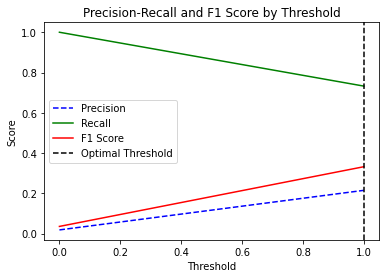

Accuracy: 0.9469036697247707
F1-Score: 0.3318903318903319


In [29]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
plt.plot(thresholds, f1_scores[:-1], 'r-', label='F1 Score')
plt.axvline(x=optimal_threshold, color='k', linestyle='--', label='Optimal Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall and F1 Score by Threshold')
plt.legend(loc='best')
plt.show()

# Step 5: Make final predictions using the optimal threshold
y_pred_optimal = (y_pred >= optimal_threshold).astype(int)
print(f'Accuracy: {accuracy_score(y_test, y_pred_optimal)}')
print(f'F1-Score: {f1_score(y_test, y_pred_optimal)}')

<h3>Data Modeling-Unsupervised Learning</h3><br>
Using unsupervised learning for stroke prediction can be quite different from supervised learning approaches.<br>
While supervised learning models predict a specific outcome based on labeled data, unsupervised learning seeks to find patterns or groupings in data without predefined labels.

Performing the same changes on the test data

In [30]:
test_data=pd.read_csv("test_2v.csv")
test_data=test_data.dropna(subset=['smoking_status', 'bmi'])
test_data=test_data.drop_duplicates()
test_data=test_data[test_data.gender!='Other']
test_data['log_bmi']=np.log(test_data['bmi'])
quantile_transformer = QuantileTransformer(output_distribution='normal', random_state=0)
test_data['cauchy_avg_glucose'] = quantile_transformer.fit_transform(test_data[['avg_glucose_level']])
test_data['uniform_age'] = quantile_transformer.fit_transform(test_data[['age']])

test_data=test_data[['id', 'gender', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type','log_bmi', 'cauchy_avg_glucose',
       'uniform_age', 'smoking_status']]
label=LabelEncoder()
for col in test_data.select_dtypes(include=['object']).columns:
    test_data[col]=label.fit_transform(test_data[col])

test_data    

,id,gender,hypertension,heart_disease,ever_married,work_type,Residence_type,log_bmi,cauchy_avg_glucose,uniform_age,smoking_status
0,36306,1,0,0,1,2,1,3.049273,-0.353357,1.895259,0
1,61829,0,0,1,1,3,0,3.258097,1.206942,1.280981,0
4,40801,0,0,0,1,0,0,3.317816,-0.366873,0.733156,1
5,9348,0,1,0,1,2,1,3.471966,1.722605,0.880888,1
7,60512,1,0,0,1,0,1,3.481240,0.808141,-0.079120,1
...,...,...,...,...,...,...,...,...,...,...,...
18594,56291,1,1,0,1,2,1,3.394508,-1.517468,-0.333524,0
18596,67353,1,0,0,0,2,0,2.912351,-0.844309,-1.425011,0
18597,362,1,0,0,1,0,0,3.453157,1.573208,0.634851,2
18598,29839,0,0,0,1,2,0,3.380995,0.878296,1.710968,1


I'll start with implementing **K-Means**. <br>
**K-Means** is a popular unsupervised machine learning algorithm used for clustering. It partitions a dataset into a predefined number of clusters (k) based on feature similarities. K-Means is a powerful clustering tool that helps uncover hidden patterns in data.

### How K-Means Works

1. **Initialization**:
   - Choose the number of clusters (k) you want to identify in the dataset.
   - Randomly initialize k centroids. These centroids are points in the feature space that represent the center of each cluster.

2. **Assignment Step**:
   - For each data point in the dataset, calculate the distance to each of the k centroids (commonly using Euclidean distance).
   - Assign each data point to the nearest centroid, forming k clusters based on the closest centroid.

3. **Update Step**:
   - Once all data points are assigned to clusters, recalculate the centroids of each cluster.
   - The new centroid is the mean of all data points assigned to that cluster.

4. **Convergence Check**:
   - Repeat the assignment and update steps until the centroids no longer change significantly, or a maximum number of iterations is reached. This indicates that the clusters have stabilized.

5. **Final Clusters**:
   - The algorithm outputs the final clusters, with each data point assigned to one of the k clusters.

### Key Concepts

- **Centroid**: The central point of a cluster, calculated as the mean of all points in that cluster.
- **Distance Metric**: Typically, Euclidean distance is used, but other metrics (like Manhattan or cosine distance) can also be applied depending on the data characteristics.
- **k**: The number of clusters. Choosing the right k is crucial and can be done using methods like the Elbow method or Silhouette score.

### Advantages of K-Means

- **Simplicity**: K-Means is straightforward to implement and understand.
- **Efficiency**: The algorithm is relatively fast and scales well with large datasets.
- **Versatility**: It can be applied to various types of data and is commonly used in clustering tasks across different domains.

In [57]:
x_train=train_data.drop(["stroke"],axis=1)
y_train=train_data["stroke"]
x_test=test_data
x_all=pd.concat([x_train, x_test], ignore_index=True, sort=False)

**Silhouette Scores** and **Inertia** are two important metrics used to evaluate the quality of clustering in algorithms like K-Means. Here's a detailed explanation of each:

**Inertia**<br>
Inertia measures how tightly the clusters are packed together. Specifically, it is defined as the sum of squared distances between each point and the centroid of the cluster to which it belongs. **Lower values of inertia indicate more compact clusters.**

**Mathematical Formula**:
$\text{Inertia} = \sum_{i=1}^{n} \sum_{j=1}^{k} ||x_i - c_j||^2 $
where:
- $n$ is the number of data points,
- $k$ is the number of clusters,
- $x_i$ is a data point, and
- $c_j$ is the centroid of the cluster.

**Use**: Inertia is used primarily in the **elbow method** to determine the optimal number of clusters (k). You plot inertia against the number of clusters; at a certain point, adding more clusters will not significantly decrease inertia. This point is considered the "elbow" and suggests a good balance between complexity and clustering quality.

**Silhouette Score**<br>
The Silhouette Score measures how similar an object is to its own cluster compared to other clusters. It takes values from -1 to 1, **where you'd want a result closer to 1**:
- A value close to 1 indicates that the data point is well-clustered (far from the neighboring clusters),
- A value close to 0 indicates that the data point is on or very close to the decision boundary between two neighboring clusters,
- A negative value indicates that the data point might have been assigned to the wrong cluster.

**Mathematical Formula**:
For a data point $i$:
$s(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))}$
where:
- $a(i)$ is the average distance between $i$ and all other points in the same cluster,
- $b(i)$ is the average distance between $i$ and all points in the nearest cluster.

**Use**: The overall silhouette score can be computed by averaging the silhouette scores of all the data points. It helps assess the appropriateness of the number of clusters chosen. Higher average silhouette scores indicate better-defined clusters.

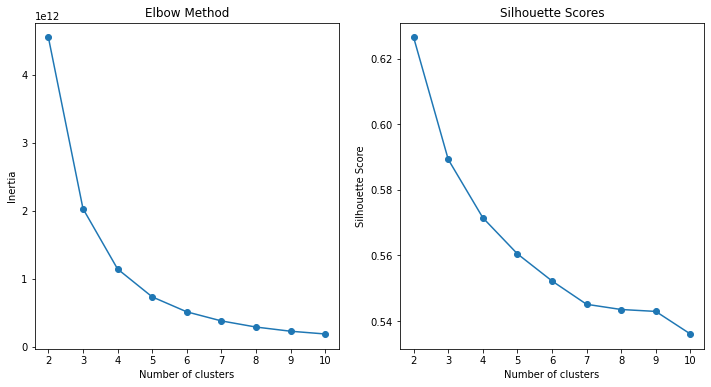

In [58]:
# Elbow method to find optimal k
inertia = []
silhouette_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(x_all)
    
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(x_all, kmeans.labels_))

# Plot the elbow method
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(2, 11), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

# Plot silhouette scores
plt.subplot(1, 2, 2)
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Scores')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()


**Principal Component Analysis (PCA)** is a statistical technique used for dimensionality reduction and data visualization. It transforms a dataset with many variables into a smaller set of uncorrelated variables called principal components while preserving as much variance (information) as possible.

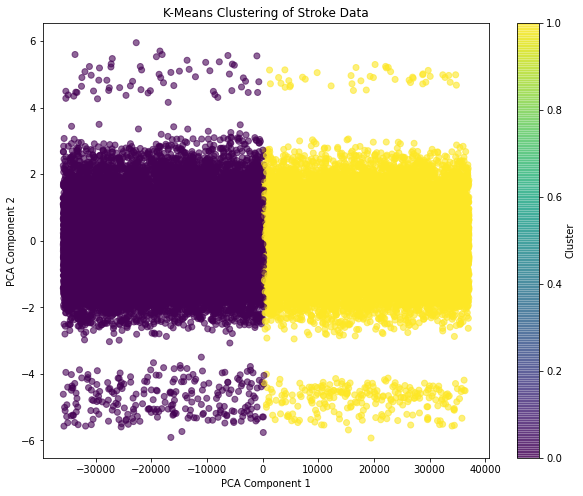

In [45]:
optimal_k = 2
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(x_all)

x_all['Cluster']=kmeans.labels_
cluster_analysis = x_all.groupby('Cluster').mean()
from sklearn.decomposition import PCA

# PCA for 2D visualization
pca = PCA(n_components=2)
features_pca = pca.fit_transform(x_all)

plt.figure(figsize=(10, 8))
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=x_all['Cluster'], cmap='viridis', alpha=0.6)
plt.title('K-Means Clustering of Stroke Data')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

To end my analysis process- I'll use **Semi-Supervised Learning**.<br>
### Semi-Supervised Learning

Semi-supervised learning combines both **supervised** and **unsupervised** learning techniques. In this paradigm, a model is trained on a small amount of labeled data (supervised) and a larger amount of unlabeled data (unsupervised). This approach is particularly useful when obtaining a fully labeled dataset is expensive or time-consuming, but you have access to a larger pool of unlabeled data.

### Key Characteristics

- **Combination of Data**: Uses both labeled and unlabeled data.
- **Improved Performance**: The goal is to leverage the unlabeled data to improve model performance beyond what could be achieved with the labeled data alone.
- **Exploration**: It often involves exploring the structure of the unlabeled data, identifying clusters or patterns that might inform the model's understanding.

This approach can help in scenarios where you have a wealth of patient data but limited labels, thus effectively utilizing available information to improve prediction accuracy.<br><br>

I'll use **XGBoost** for the Supervised algorithm
   - **Pros**: Highly efficient, handles large datasets well, and often achieves state-of-the-art results.
   - **Cons**: More complex to tune due to many hyperparameters.

and **K-Means Clustering** for the Unsupervised algorithm
   - **Pros**: Simple and fast; helps in identifying groups of similar patients based on features.
   - **Cons**: Requires specifying the number of clusters beforehand; sensitive to outliers. 

This combination can help improve your understanding of stroke risks and patient characteristics, leading to more informed clinical decisions.

Supervised Model Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.90      0.71      8520
           1       0.80      0.38      0.51      8548

    accuracy                           0.64     17068
   macro avg       0.69      0.64      0.61     17068
weighted avg       0.69      0.64      0.61     17068

Silhouette Score: 0.62


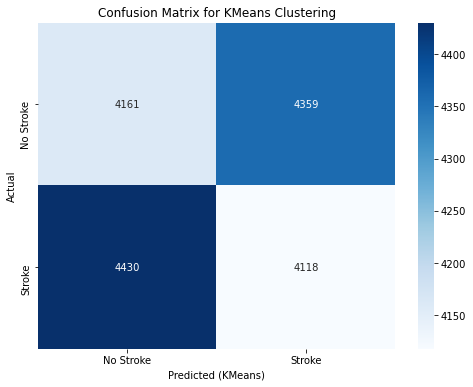

In [60]:
# Assume the last column is the target variable
X=train_data.drop(["stroke"],axis=1)
y=train_data["stroke"]
adasyn = ADASYN(random_state=42)
x_train_xgb, y_train_xgb = adasyn.fit_resample(X, y)

# Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(x_train_xgb, y_train_xgb, test_size=0.3, random_state=42)

# Supervised learning with XGBoost
xgb_model = XGBClassifier(
    random_state=42,
    scale_pos_weight=2,
    use_label_encoder=False,
    eval_metric='logloss')
#xgb_model.fit(X_train, y_train)

from sklearn.model_selection import GridSearchCV
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
grid_search = GridSearchCV(xgb_model, param_grid, cv=3, scoring='f1')
grid_search.fit(X_train, y_train)
best_xgb_model = grid_search.best_estimator_

# Predictions on the test set
y_pred = best_xgb_model.predict(X_test_scaled)

# Evaluate supervised model
print("Supervised Model Classification Report:")
print(classification_report(y_test, y_pred))

# Unsupervised learning with KMeans
kmeans = KMeans(n_clusters=2, random_state=42)
X_test_kmeans = kmeans.fit_predict(X_test)

# Evaluate unsupervised model using Silhouette Score
silhouette_avg = silhouette_score(X_test, X_test_kmeans)
print(f'Silhouette Score: {silhouette_avg:.2f}')

# Confusion matrix for KMeans clustering
conf_matrix = confusion_matrix(y_test, X_test_kmeans)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Stroke', 'Stroke'], yticklabels=['No Stroke', 'Stroke'])
plt.ylabel('Actual')
plt.xlabel('Predicted (KMeans)')
plt.title('Confusion Matrix for KMeans Clustering')
plt.show()


In [54]:
# Perform K-Fold Cross-Validation
scores = cross_val_score(best_xgb_model, X, y, cv=5)  # cv=5 for 5-fold
print(f'Cross-Validation Scores: {scores}')
print(f'Mean Score: {scores.mean()}')

Cross-Validation Scores: [0.98004473 0.98004473 0.97952864 0.98056081 0.97952864]
Mean Score: 0.9799415104077068
